# Q1a Analysis: Scatter Plots

This notebook analyzes model performance on Q1a tasks (finding the largest common motif in ChEMBL molecules) using scatter plots.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

# Set style for plots - clean, no grid
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

custom_colors = ['#FF6B35', '#2E86AB', '#06A77D']  # Orange, Blue, Teal - high contrast

## Helper Functions

In [2]:
def calculate_dbe(smiles):
    """Calculate Double Bond Equivalents (Degree of Unsaturation)"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    c_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
    n_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'N')
    h_count = sum(atom.GetTotalNumHs() for atom in mol.GetAtoms())
    x_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() in ['F', 'Cl', 'Br', 'I'])
    
    dbe = (2 * c_count + 2 + n_count - h_count - x_count) / 2
    return dbe

def get_num_atoms(smiles):
    """Get number of heavy atoms in molecule"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol.GetNumHeavyAtoms()

def is_substructure(query_smiles, target_smiles):
    """Check if query is a substructure of target"""
    query_mol = Chem.MolFromSmiles(query_smiles)
    target_mol = Chem.MolFromSmiles(target_smiles)
    
    if query_mol is None or target_mol is None:
        return False
    
    return target_mol.HasSubstructMatch(query_mol)

def calculate_overlap_metric(response_smiles, correct_smiles):
    """Calculate atom overlap metric: N_overlap / max(N_response, N_correct)"""
    response_mol = Chem.MolFromSmiles(response_smiles)
    correct_mol = Chem.MolFromSmiles(correct_smiles)
    
    if response_mol is None or correct_mol is None:
        return 0.0
    
    n_response = response_mol.GetNumHeavyAtoms()
    n_correct = correct_mol.GetNumHeavyAtoms()
    
    if correct_mol.HasSubstructMatch(response_mol):
        n_overlap = n_response
    elif response_mol.HasSubstructMatch(correct_mol):
        n_overlap = n_correct
    else:
        from rdkit.Chem import rdFMCS
        mcs = rdFMCS.FindMCS([response_mol, correct_mol], timeout=5)
        if mcs.smartsString:
            mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            if mcs_mol:
                n_overlap = mcs_mol.GetNumHeavyAtoms()
            else:
                n_overlap = 0
        else:
            n_overlap = 0
    
    max_atoms = max(n_response, n_correct)
    if max_atoms == 0:
        return 0.0
    
    return n_overlap / max_atoms

## Load Data

In [3]:
# Load the dataset to get ground truth and metadata
dataset = []
with open('data/dataset_q1a_fixed_smiles.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))

# Filter for Q1a tasks only
q1a_dataset = [d for d in dataset if d['task'] == 'q1a_largest_common_motif_chembl']

# Create a lookup by instance ID
dataset_lookup = {d['id']: d for d in q1a_dataset}

print(f"Total Q1a instances in dataset: {len(q1a_dataset)}")

Total Q1a instances in dataset: 1016


In [4]:
# Define the runs to analyze - Q1a only
run_files = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
]

# Load all runs
all_results = []

for model_name, file_path in run_files:
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        continue
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            all_results.append(result)

print(f"\nTotal results loaded: {len(all_results)}")
print(f"Models: {set(r['model_name'] for r in all_results)}")


Total results loaded: 3048
Models: {'claude-opus-4-5', 'gpt-5.2', 'gemini-3-pro-preview'}


## Compute Enriched Metrics

In [5]:
# Enrich results with additional metrics
enriched_results = []

for result in all_results:
    instance_id = result['id']
    
    if instance_id not in dataset_lookup:
        print(f"Warning: {instance_id} not found in dataset")
        continue
    
    dataset_info = dataset_lookup[instance_id]
    
    correct_smiles = result['score'].get('gold_canonical') or result['score'].get('gold')
    response_smiles = result['score'].get('pred_canonical') or result['score'].get('pred')
    
    if response_smiles is None:
        enriched = {
            'id': instance_id,
            'model': result['model_name'],
            'n_molecules': result['n_molecules'],
            'correct': result['score']['correct'],
            'response_smiles': None,
            'correct_smiles': correct_smiles,
            'response_is_substructure_of_correct': False,
            'correct_is_substructure_of_response': False,
            'overlap_metric': 0.0,
            'n_atoms_response': 0,
            'n_atoms_correct': get_num_atoms(correct_smiles) if correct_smiles else None,
            'dbe_response': None,
            'dbe_correct': calculate_dbe(correct_smiles) if correct_smiles else None,
            'avg_n_atoms_molecules': np.mean([get_num_atoms(m) for m in dataset_info['molecules'] if get_num_atoms(m) is not None]),
            'avg_dbe_molecules': np.mean([calculate_dbe(m) for m in dataset_info['molecules'] if calculate_dbe(m) is not None]),
        }
        enriched_results.append(enriched)
        continue
    
    response_is_sub = is_substructure(response_smiles, correct_smiles) if correct_smiles else False
    correct_is_sub = is_substructure(correct_smiles, response_smiles) if correct_smiles else False
    overlap = calculate_overlap_metric(response_smiles, correct_smiles) if correct_smiles else 0.0
    
    n_atoms_response = get_num_atoms(response_smiles)
    n_atoms_correct = get_num_atoms(correct_smiles) if correct_smiles else None
    
    dbe_response = calculate_dbe(response_smiles)
    dbe_correct = calculate_dbe(correct_smiles) if correct_smiles else None
    
    molecule_atoms = [get_num_atoms(m) for m in dataset_info['molecules']]
    molecule_atoms = [a for a in molecule_atoms if a is not None]
    avg_n_atoms_molecules = np.mean(molecule_atoms) if molecule_atoms else None
    
    molecule_dbes = [calculate_dbe(m) for m in dataset_info['molecules']]
    molecule_dbes = [d for d in molecule_dbes if d is not None]
    avg_dbe_molecules = np.mean(molecule_dbes) if molecule_dbes else None
    
    enriched = {
        'id': instance_id,
        'model': result['model_name'],
        'n_molecules': result['n_molecules'],
        'correct': result['score']['correct'],
        'response_smiles': response_smiles,
        'correct_smiles': correct_smiles,
        'response_is_substructure_of_correct': response_is_sub,
        'correct_is_substructure_of_response': correct_is_sub,
        'overlap_metric': overlap,
        'n_atoms_response': n_atoms_response,
        'n_atoms_correct': n_atoms_correct,
        'dbe_response': dbe_response,
        'dbe_correct': dbe_correct,
        'avg_n_atoms_molecules': avg_n_atoms_molecules,
        'avg_dbe_molecules': avg_dbe_molecules,
    }
    
    enriched_results.append(enriched)

# Convert to DataFrame
df = pd.DataFrame(enriched_results)

print(f"\nEnriched results: {len(df)} instances")
print(f"\nSample of enriched data:")
print(df.head())

[21:06:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[21:06:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[21:06:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[21:06:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[21:06:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[21:06:51] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[21:06:51] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[21:06:51] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[21:06:51] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[21:06:51] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[21:07:04] SMILES Parse Error: unclosed ring for input: 'CC1(C2CCC3=CC(=O)C=CC3(C)C2C(O)CC2(C)C1CC1C)C'
[21:07:04] SMILES Parse Error: unclosed ring for input: 'CC1(C2CCC3=CC(=O)C=CC3(C)C2C(O)CC2(C)C1CC1C)C'
[21:07:04] SMILES Parse Error: unclosed ring for input: 'CC1(C2CCC3=CC(=O)C=CC3(C)C2C(O)CC2(C)C1CC1C)C'
[21


Enriched results: 3048 instances

Sample of enriched data:
             id            model  n_molecules  correct  \
0  q1a_n5_00001  claude-opus-4-5            5     True   
1  q1a_n5_00002  claude-opus-4-5            5    False   
2  q1a_n5_00003  claude-opus-4-5            5    False   
3  q1a_n5_00004  claude-opus-4-5            5    False   
4  q1a_n5_00005  claude-opus-4-5            5    False   

                         response_smiles                   correct_smiles  \
0                         O=CC1CCC(=O)N1                   O=CC1CCC(=O)N1   
1                      O=c1[nH]c(=O)ncc1   O=c1ccn(C2CCC(CO)O2)c(=O)[nH]1   
2           c1ccc(N2CCN(c3ccccc3)CC2)cc1                  CCN(CC)c1ccccc1   
3                               C1COCCN1                       CCN1CCOCC1   
4  NCC1CC(O)C(O)C(OC2C(N)CC(N)C(O)C2O)O1  NCC1CCCC(OC2C(N)CC(N)C(O)C2O)O1   

   response_is_substructure_of_correct  correct_is_substructure_of_response  \
0                                 True           

## Scatter Plots by Number of Molecules

In [6]:
df.groupby('model').agg({'correct': 'mean', 'overlap_metric': 'mean'}).sort_values('correct', ascending=False)

,correct,overlap_metric
model,,
claude-opus-4-5,0.180118,0.785402
gemini-3-pro-preview,0.125984,0.691207
gpt-5.2,0.093504,0.680561


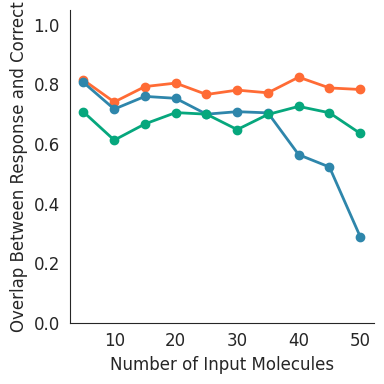

In [7]:
plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(1,1, figsize=(4, 4))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

ax1 = axes
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['overlap_metric'].mean().reset_index()
    ax1.plot(grouped['n_molecules'], grouped['overlap_metric'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Input Molecules')
ax1.set_ylabel('Overlap Between Response and Correct')
# ax1.set_title('Overall Accuracy vs Number of Molecules')
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)
# fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()
plt.show()


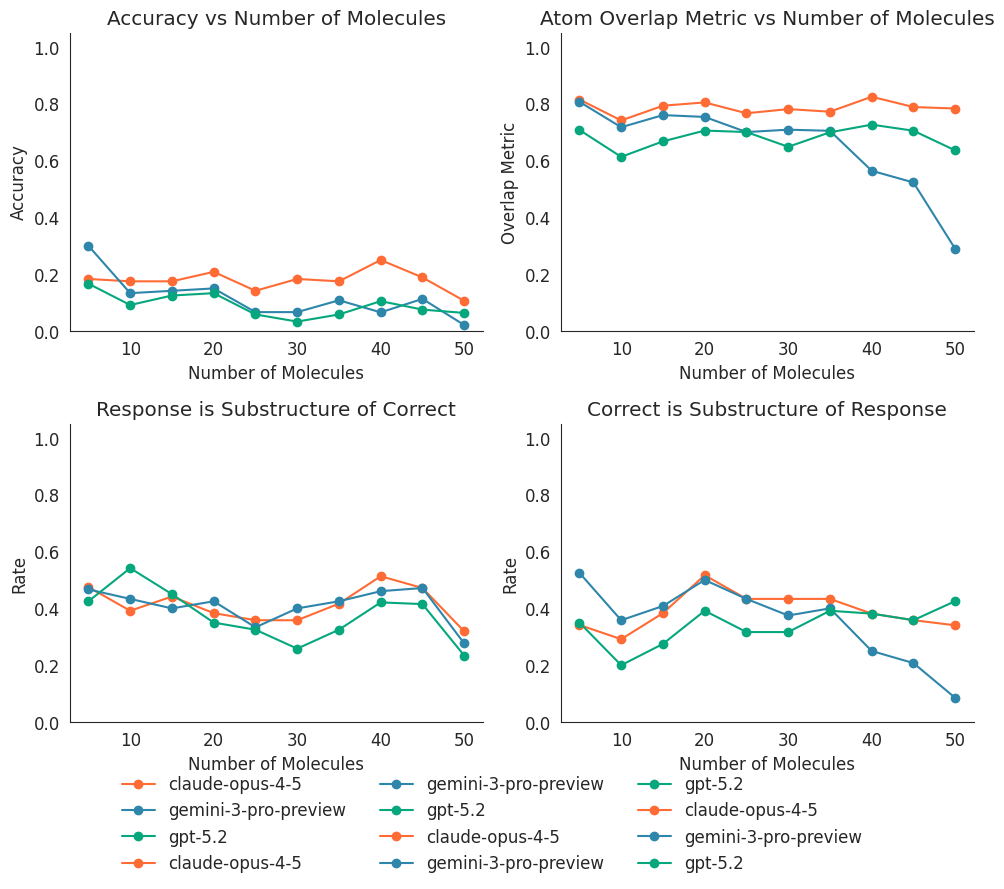

In [8]:
# Scatter plots for each metric
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Get unique models and assign colors
models = sorted(df['model'].unique())
model_color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Accuracy by n_molecules
ax1 = axes[0, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['correct'].mean().reset_index()
    ax1.plot(grouped['n_molecules'], grouped['correct'], marker='o', label=model, color=model_color_map[model])
ax1.set_xlabel('Number of Molecules')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Number of Molecules')
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Overlap metric by n_molecules
ax2 = axes[0, 1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['overlap_metric'].mean().reset_index()
    ax2.plot(grouped['n_molecules'], grouped['overlap_metric'], marker='o', label=model, color=model_color_map[model])
ax2.set_xlabel('Number of Molecules')
ax2.set_ylabel('Overlap Metric')
ax2.set_title('Atom Overlap Metric vs Number of Molecules')
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# Response is substructure of correct
ax3 = axes[1, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['response_is_substructure_of_correct'].mean().reset_index()
    ax3.plot(grouped['n_molecules'], grouped['response_is_substructure_of_correct'], marker='o', label=model, color=model_color_map[model])
ax3.set_xlabel('Number of Molecules')
ax3.set_ylabel('Rate')
ax3.set_title('Response is Substructure of Correct')
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

# Correct is substructure of response
ax4 = axes[1, 1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['correct_is_substructure_of_response'].mean().reset_index()
    ax4.plot(grouped['n_molecules'], grouped['correct_is_substructure_of_response'], marker='o', label=model, color=model_color_map[model])
ax4.set_xlabel('Number of Molecules')
ax4.set_ylabel('Rate')
ax4.set_title('Correct is Substructure of Response')
ax4.set_ylim([0, 1.05])
sns.despine(ax=ax4)

# Add single legend at the bottom with 3 columns
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.12), frameon=False)

plt.tight_layout()
plt.show()

Model: claude-opus-4-5, are_substructures: 0.6289370078740157
Model: gemini-3-pro-preview, are_substructures: 0.6742125984251969
Model: gpt-5.2, are_substructures: 0.6181102362204725


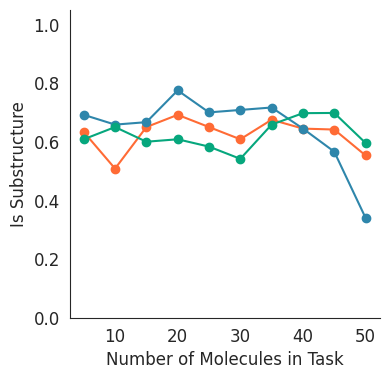

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
for model in models:
    subset = df[df['model'] == model].copy()
    subset['are_substructures'] = subset['correct_is_substructure_of_response'] | subset['response_is_substructure_of_correct']
    print(f"Model: {model}, are_substructures: {subset['are_substructures'].mean()}")
    grouped = subset.groupby('n_molecules')['are_substructures'].mean().reset_index()
    ax.plot(grouped['n_molecules'], grouped['are_substructures'], marker='o', label=model, color=model_color_map[model])
ax.set_xlabel('Number of Molecules in Task')
ax.set_ylabel('Is Substructure') # is substructure
ax.set_ylim([0, 1.05])
sns.despine(ax=ax)

## Scatter Plots by Motif Size

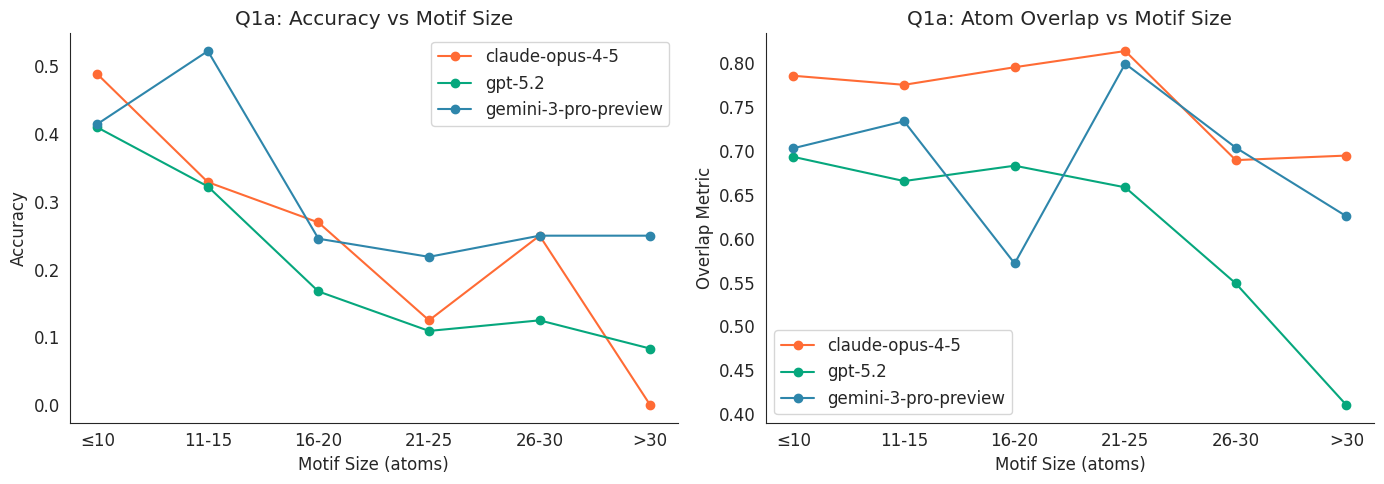

In [10]:
# Create bins for motif size
df['motif_size_bin'] = pd.cut(df['n_atoms_correct'], bins=[0, 10, 15, 20, 25, 30, 100], labels=['≤10', '11-15', '16-20', '21-25', '26-30', '>30'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy by motif size
ax1 = axes[0]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('motif_size_bin', observed=True)['correct_is_substructure_of_response'].mean().reset_index()
    ax1.plot(grouped['motif_size_bin'], grouped['correct_is_substructure_of_response'], marker='o', label=model, color=model_color_map[model])
ax1.set_xlabel('Motif Size (atoms)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Q1a: Accuracy vs Motif Size')
ax1.legend()
sns.despine(ax=ax1)

# Overlap metric by motif size
ax2 = axes[1]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('motif_size_bin', observed=True)['overlap_metric'].mean().reset_index()
    ax2.plot(grouped['motif_size_bin'], grouped['overlap_metric'], marker='o', label=model, color=model_color_map[model])
ax2.set_xlabel('Motif Size (atoms)')
ax2.set_ylabel('Overlap Metric')
ax2.set_title('Q1a: Atom Overlap vs Motif Size')
ax2.legend()
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

## Scatter Plots by Input Molecule Size

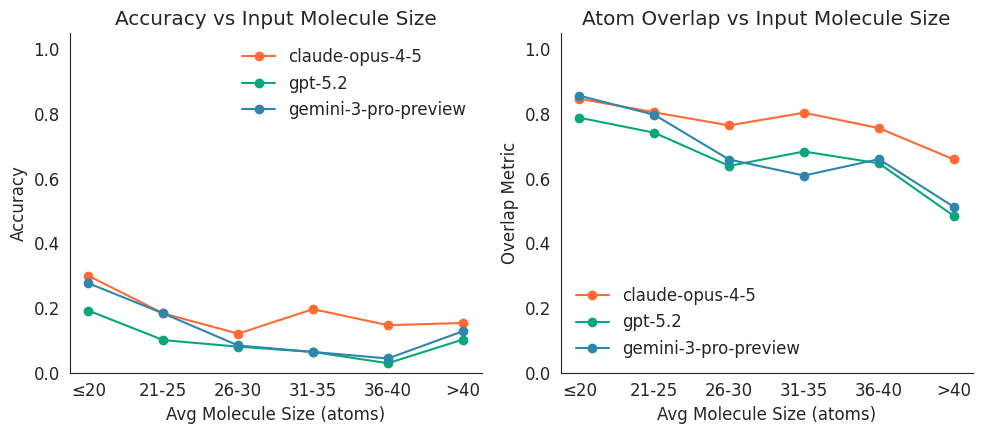

In [11]:
# Create bins for molecule size
df['molecule_size_bin'] = pd.cut(df['avg_n_atoms_molecules'], bins=[0, 20, 25, 30, 35, 40, 100], labels=['≤20', '21-25', '26-30', '31-35', '36-40', '>40'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# Accuracy by molecule size
ax1 = axes[0]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('molecule_size_bin', observed=True)['correct'].mean().reset_index()
    ax1.plot(grouped['molecule_size_bin'], grouped['correct'], marker='o', label=model, color=model_color_map[model])
ax1.set_xlabel('Avg Molecule Size (atoms)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Input Molecule Size')
ax1.legend(frameon=False)
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Overlap metric by molecule size
ax2 = axes[1]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('molecule_size_bin', observed=True)['overlap_metric'].mean().reset_index()
    ax2.plot(grouped['molecule_size_bin'], grouped['overlap_metric'], marker='o', label=model, color=model_color_map[model])
ax2.set_xlabel('Avg Molecule Size (atoms)')
ax2.set_ylabel('Overlap Metric')
ax2.set_title('Atom Overlap vs Input Molecule Size')
ax2.legend(frameon=False)
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

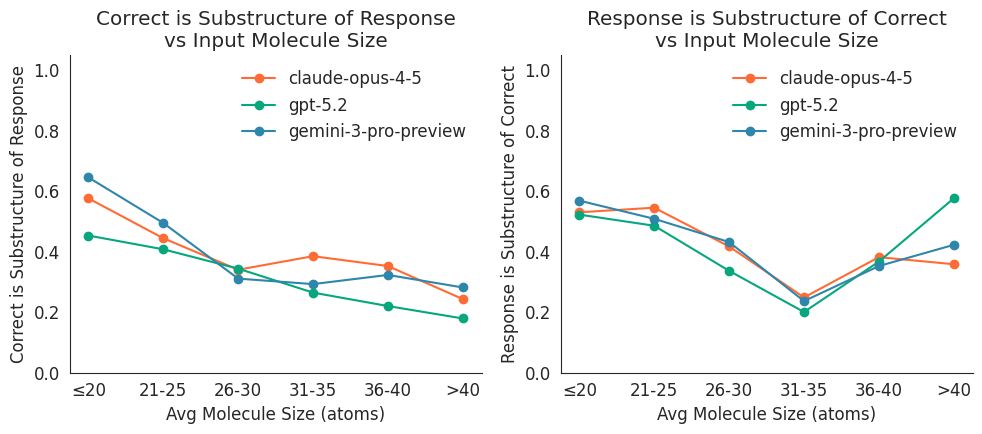

In [12]:
# Create bins for molecule size
df['molecule_size_bin'] = pd.cut(df['avg_n_atoms_molecules'], bins=[0, 20, 25, 30, 35, 40, 100], labels=['≤20', '21-25', '26-30', '31-35', '36-40', '>40'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# Accuracy by molecule size
ax1 = axes[0]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('molecule_size_bin', observed=True)['correct_is_substructure_of_response'].mean().reset_index()
    ax1.plot(grouped['molecule_size_bin'], grouped['correct_is_substructure_of_response'], marker='o', label=model, color=model_color_map[model])
ax1.set_xlabel('Avg Molecule Size (atoms)')
ax1.set_ylabel('Correct is Substructure of Response')
ax1.set_title('Correct is Substructure of Response\nvs Input Molecule Size')
ax1.legend(frameon=False)
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Overlap metric by molecule size
ax2 = axes[1]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('molecule_size_bin', observed=True)['response_is_substructure_of_correct'].mean().reset_index()
    ax2.plot(grouped['molecule_size_bin'], grouped['response_is_substructure_of_correct'], marker='o', label=model, color=model_color_map[model])
ax2.set_xlabel('Avg Molecule Size (atoms)')
ax2.set_ylabel('Response is Substructure of Correct')
ax2.set_title('Response is Substructure of Correct\nvs Input Molecule Size')
ax2.legend(frameon=False)
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

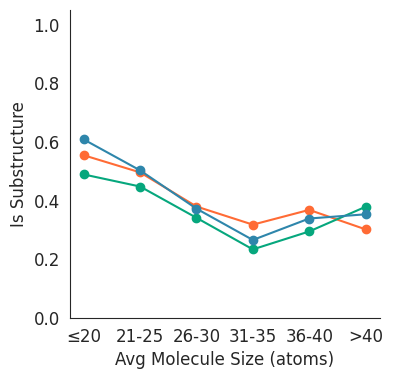

In [16]:
# Create bins for molecule size
df['molecule_size_bin'] = pd.cut(df['avg_n_atoms_molecules'], bins=[0, 20, 25, 30, 35, 40, 100], labels=['≤20', '21-25', '26-30', '31-35', '36-40', '>40'])

fig, axes = plt.subplots(1, 1, figsize=(4,4))

# Accuracy by molecule size
ax1 = axes
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('molecule_size_bin', observed=True)['correct_is_substructure_of_response'].mean().reset_index()
    grouped2 = subset.groupby('molecule_size_bin', observed=True)['response_is_substructure_of_correct'].mean().reset_index()
    grouped = pd.merge(grouped, grouped2, on='molecule_size_bin', how='outer')
    grouped['is_substructure'] = 0.5*(grouped['correct_is_substructure_of_response'] + grouped['response_is_substructure_of_correct'])
    ax1.plot(grouped['molecule_size_bin'], grouped['is_substructure'], marker='o', label=model, color=model_color_map[model])
ax1.set_xlabel('Avg Molecule Size (atoms)')
ax1.set_ylabel('Is Substructure')
# ax1.set_title('Is Substructure vs Input Molecule Size')
# ax1.legend(frameon=False)
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

## Scatter Plots by DBE (Double Bond Equivalents)

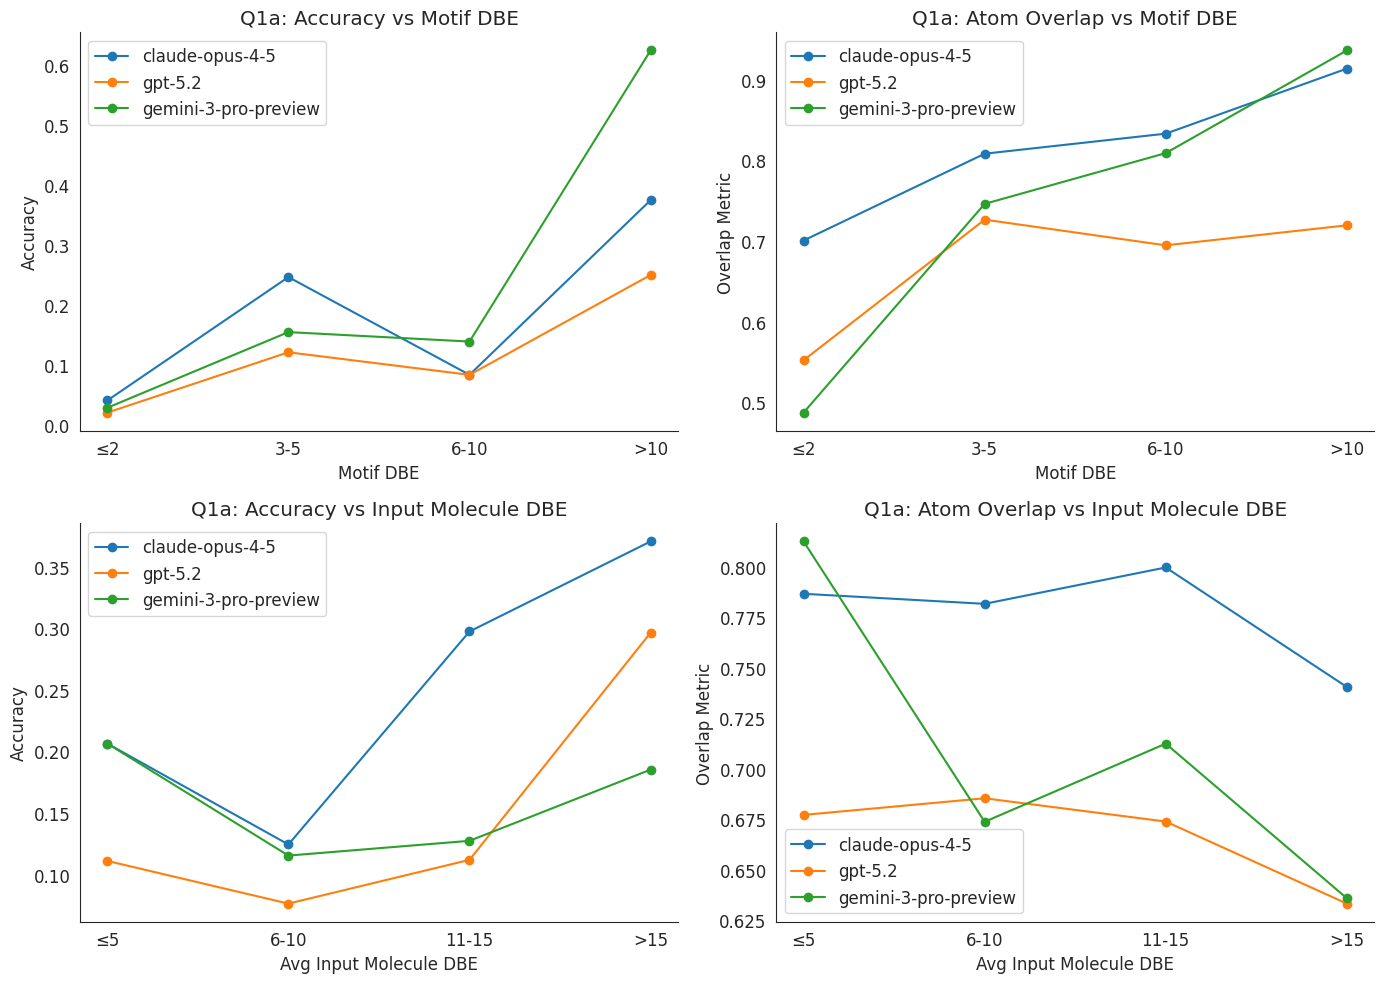

In [14]:
# Create bins for DBE
df['dbe_motif_bin'] = pd.cut(df['dbe_correct'], bins=[-1, 2, 5, 10, 100], labels=['≤2', '3-5', '6-10', '>10'])
df['dbe_molecules_bin'] = pd.cut(df['avg_dbe_molecules'], bins=[-1, 5, 10, 15, 100], labels=['≤5', '6-10', '11-15', '>15'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy by DBE of motif
ax1 = axes[0, 0]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('dbe_motif_bin', observed=True)['correct'].mean().reset_index()
    ax1.plot(grouped['dbe_motif_bin'], grouped['correct'], marker='o', label=model)
ax1.set_xlabel('Motif DBE')
ax1.set_ylabel('Accuracy')
ax1.set_title('Q1a: Accuracy vs Motif DBE')
ax1.legend()
sns.despine(ax=ax1)

# Overlap metric by DBE of motif
ax2 = axes[0, 1]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('dbe_motif_bin', observed=True)['overlap_metric'].mean().reset_index()
    ax2.plot(grouped['dbe_motif_bin'], grouped['overlap_metric'], marker='o', label=model)
ax2.set_xlabel('Motif DBE')
ax2.set_ylabel('Overlap Metric')
ax2.set_title('Q1a: Atom Overlap vs Motif DBE')
ax2.legend()
sns.despine(ax=ax2)

# Accuracy by DBE of input molecules
ax3 = axes[1, 0]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('dbe_molecules_bin', observed=True)['correct'].mean().reset_index()
    ax3.plot(grouped['dbe_molecules_bin'], grouped['correct'], marker='o', label=model)
ax3.set_xlabel('Avg Input Molecule DBE')
ax3.set_ylabel('Accuracy')
ax3.set_title('Q1a: Accuracy vs Input Molecule DBE')
ax3.legend()
sns.despine(ax=ax3)

# Overlap metric by DBE of input molecules
ax4 = axes[1, 1]
for model in df['model'].unique():
    subset = df[df['model'] == model]
    grouped = subset.groupby('dbe_molecules_bin', observed=True)['overlap_metric'].mean().reset_index()
    ax4.plot(grouped['dbe_molecules_bin'], grouped['overlap_metric'], marker='o', label=model)
ax4.set_xlabel('Avg Input Molecule DBE')
ax4.set_ylabel('Overlap Metric')
ax4.set_title('Q1a: Atom Overlap vs Input Molecule DBE')
ax4.legend()
sns.despine(ax=ax4)

plt.tight_layout()
plt.show()